# 2A.ml - Réduction d'une forêt aléatoire - correction

Le modèle Lasso permet de sélectionner des variables, une forêt aléatoire produit une prédiction comme étant la moyenne d'arbres de régression. Et si on mélangeait les deux ?

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Datasets

Comme il faut toujours des données, on prend ce jeu [Diabetes](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html).

In [3]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X, y = data.data, data.target

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Une forêt aléatoire

In [5]:
from sklearn.ensemble import RandomForestRegressor as model_class
clr = model_class()
clr.fit(X_train, y_train)

RandomForestRegressor()

Le nombre d'arbres est...

In [6]:
len(clr.estimators_)

100

In [7]:
from sklearn.metrics import r2_score
r2_score(y_test, clr.predict(X_test))

0.3625404922781166

## Random Forest = moyenne des prédictions

On recommence en faisant la moyenne soi-même.

In [8]:
import numpy
dest = numpy.zeros((X_test.shape[0], len(clr.estimators_)))
estimators = numpy.array(clr.estimators_).ravel()
for i, est in enumerate(estimators):
    pred = est.predict(X_test)
    dest[:, i] = pred

average = numpy.mean(dest, axis=1)
r2_score(y_test, average)

0.3625404922781166

A priori, c'est la même chose.

## Pondérer les arbres à l'aide d'une régression linéaire

La forêt aléatoire est une façon de créer de nouvelles features, 100 exactement qu'on utilise pour caler une régression linéaire.

In [9]:
from sklearn.linear_model import LinearRegression


def new_features(forest, X):
    dest = numpy.zeros((X.shape[0], len(forest.estimators_)))
    estimators = numpy.array(forest.estimators_).ravel()
    for i, est in enumerate(estimators):
        pred = est.predict(X)
        dest[:, i] = pred
    return dest


X_train_2 = new_features(clr, X_train)
lr = LinearRegression()
lr.fit(X_train_2, y_train)

LinearRegression()

In [10]:
X_test_2 = new_features(clr, X_test)
r2_score(y_test, lr.predict(X_test_2))

0.30414556638121215

Un peu moins bien, un peu mieux, le risque d'overfitting est un peu plus grand avec ces nombreuses features car la base d'apprentissage ne contient que 379 observations (regardez ``X_train.shape`` pour vérifier).

In [11]:
lr.coef_

array([ 0.0129567 , -0.03467343, -0.02574902,  0.01872549,  0.00128276,
       -0.01449147,  0.00977528, -0.02397026,  0.01066261,  0.02121925,
        0.03544455,  0.02735311,  0.01859875, -0.03189411, -0.0245749 ,
       -0.01879966,  0.01521987,  0.00292998,  0.04250576,  0.01424533,
       -0.00561623,  0.00635399,  0.04712406,  0.02518721,  0.01713507,
        0.01741708, -0.02072389,  0.05748854,  0.00424951,  0.02872275,
       -0.01016485,  0.04368062,  0.07377962,  0.06540726, -0.00123185,
        0.02227104,  0.0289425 ,  0.00914512,  0.03645644,  0.01838009,
        0.00046509,  0.04145444,  0.0202303 ,  0.00984027,  0.0149448 ,
       -0.01129977,  0.00428108,  0.02601842,  0.00421449, -0.01172942,
        0.02631074,  0.04180424,  0.02909078, -0.01922766, -0.00953341,
       -0.0036882 , -0.02411783,  0.06700977, -0.01447105,  0.02094102,
        0.00227497,  0.04181756, -0.02474879,  0.0465355 ,  0.05504502,
       -0.05645067, -0.02066304,  0.04349629, -0.01549704,  0.02

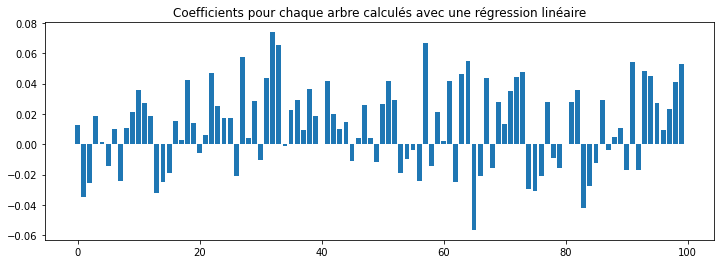

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.bar(numpy.arange(0, len(lr.coef_)), lr.coef_)
ax.set_title("Coefficients pour chaque arbre calculés avec une régression linéaire");

Le score est avec une régression linéaire sur les variables initiales est nettement moins élevé.

In [13]:
lr_raw = LinearRegression()
lr_raw.fit(X_train, y_train)
r2_score(y_test, lr_raw.predict(X_test))

0.5103612609676136

## Sélection d'arbres

L'idée est d'utiliser un algorithme de sélection de variables type [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) pour réduire la forêt aléatoire sans perdre en performance. C'est presque le même code.

In [14]:
from sklearn.linear_model import Lasso

lrs = Lasso(max_iter=10000)
lrs.fit(X_train_2, y_train)
lrs.coef_

array([ 0.01256934, -0.03342528, -0.02400605,  0.01825851,  0.0005323 ,
       -0.01374509,  0.01004616, -0.02284903,  0.01105419,  0.02047233,
        0.03476362,  0.02755575,  0.01751674, -0.03051477, -0.02321124,
       -0.01783216,  0.01429992,  0.00214398,  0.04066576,  0.0134879 ,
       -0.00377705,  0.00506043,  0.04614375,  0.02482044,  0.01560689,
        0.01706262, -0.02035898,  0.05747191,  0.00418486,  0.02766988,
       -0.00899098,  0.04325266,  0.07327657,  0.06515135, -0.00034774,
        0.02210777,  0.0280344 ,  0.00852669,  0.0358763 ,  0.01779845,
        0.        ,  0.03970822,  0.01935286,  0.00908017,  0.01417323,
       -0.01066044,  0.00293442,  0.02483663,  0.00332255, -0.01043329,
        0.02666477,  0.04097776,  0.02851599, -0.01795373, -0.00830115,
       -0.00293032, -0.02188798,  0.06679156, -0.01364001,  0.02028321,
        0.00160792,  0.04114419, -0.02342478,  0.04638246,  0.0547764 ,
       -0.05501755, -0.01856303,  0.04157578, -0.01403205,  0.02

Pas mal de zéros donc pas mal d'arbres non utilisés.

In [15]:
r2_score(y_test, lrs.predict(X_test_2))

0.3055529526371402

Pas trop de perte... Ca donne envie d'essayer plusieurs valeur de `alpha`.

In [16]:
from tqdm import tqdm
alphas = [0.01 * i for i in range(100)] +[1 + 0.1 * i for i in range(100)]
obs = []
for i in tqdm(range(0, len(alphas))):
    alpha = alphas[i]
    lrs = Lasso(max_iter=20000, alpha=alpha)
    lrs.fit(X_train_2, y_train)
    obs.append(dict(
        alpha=alpha,
        null=len(lrs.coef_[lrs.coef_!=0]),
        r2=r2_score(y_test, lrs.predict(X_test_2))
    ))

  0%|          | 0/200 [00:00<?, ?it/s]C:\Users\xavie\AppData\Local\Temp\ipykernel_18252\1667502338.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lrs.fit(X_train_2, y_train)
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_coordinate_descent.py:634: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.572e+04, tolerance: 1.993e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

In [17]:
from pandas import DataFrame
df = DataFrame(obs)
df.tail()

,alpha,null,r2
195,10.5,83,0.318660
196,10.6,83,0.318771
197,10.7,83,0.318879
198,10.8,83,0.318982
199,10.9,82,0.319073


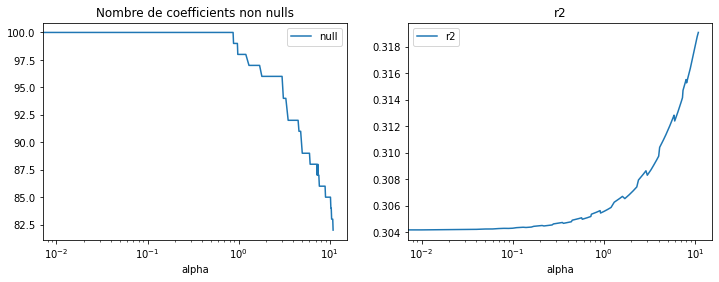

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
df[["alpha", "null"]].set_index("alpha").plot(ax=ax[0], logx=True)
ax[0].set_title("Nombre de coefficients non nulls")
df[["alpha", "r2"]].set_index("alpha").plot(ax=ax[1], logx=True)
ax[1].set_title("r2");

Dans ce cas, supprimer des arbres augmente la performance, comme évoqué ci-dessus, cela réduit l'overfitting. Le nombre d'arbres peut être réduit des deux tiers avec ce modèle.